In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import gpflow
#import tensorflow as tf
#import sys
#sys.path.append('../code')
#from gplar import GPLARegressor
#from gpar.regression import GPARRegressor
#from gpflow.ci_utils import ci_niter

In [2]:
logliks_gpar, smses_gpar = [],[]
logliks_gplar, smses_gplar = [],[]

In [3]:
def generate_data(noise, N):
    x = np.linspace(0.0,1.0,N).reshape(N,1)
    
    f1 = lambda x: -np.sin(10*np.pi*(x+1))/(2*x+1)-x**4
    h1 = lambda x: f1(x) + np.random.normal(0,1e-5)
    f2 = lambda x: np.cos(h1(x))**2 + np.sin(3*x)
    h2 = lambda x: f2(x) + np.random.normal(0,1e-5)
    f3 = lambda x: h2(x)*h1(x)**2 + 3*x
    h3 = lambda x: f3(x) + np.random.normal(0,1e-5)
    
    y1 = np.array(list(map(h1,x))) + np.random.normal(0,noise,N).reshape(N,1)
    y2 = np.array(list(map(h2,x))) + np.random.normal(0,noise,N).reshape(N,1)
    y3 = np.array(list(map(h3,x))) + np.random.normal(0,noise,N).reshape(N,1)

    return x, np.concatenate((y1,y2,y3),axis=1)

In [4]:
def initial_model_on_data(x, y, M):
    gpar  = GPARRegressor(scale=0.1,
                  linear=True, linear_scale=10.,
                  nonlinear=True, nonlinear_scale=0.1,
                  noise=0.05,
                  impute=True, replace=True, normalise_y=True)

    gplar = GPLARegressor(x, y, M, gpar, white=False,
             scale=0.1,
             linear=True, linear_scale=10.0,
             nonlinear=True, nonlinear_scale=0.1,
             noise_inner=1e-5, noise_obs=0.05,
             num_samples=1)

    return gpar, gplar

In [5]:
def assess_gplar(model, x, y, num_samples):
    loglik, smse = [],[]
    Hmeans, Hvars = model._predict(x, S=num_samples)
    for i, likelihood in enumerate(model.likelihoods):
        mean, var = np.squeeze(Hmeans[i]), np.squeeze(Hvars[i])
        #[S,N]
        
        l = likelihood.predict_log_density(mean, var, y[:,i]) #[S,]
        log_num_samples = tf.math.log(tf.cast(num_samples, l.dtype))
        log_likelihood = tf.reduce_logsumexp(l - log_num_samples, axis=0)
        loglik.append(log_likelihood.numpy())
        
        mean = np.average(mean, 0) #[N,]
        smsei = np.mean((mean-y[:,i])**2)/np.mean((np.mean(y[:,i])-y[:,i])**2)
        smse.append(smsei)
    return loglik, smse

def assess_gpar(model, x, y, num_samples):
    loglik, smse= [],[]
    means, lowers, uppers = model.predict(x, num_samples=num_samples, credible_bounds=True, latent=True)
    for i in range(y.shape[1]):
        mean, var = means[:,i], ((uppers[:,i]-means[:,i])/1.96)**2
        log_likelihood = np.sum(-0.5*(np.log(2*np.pi)+np.log(var)+np.square(y[:,i] - mean)/var))
        loglik.append(log_likelihood)
        
        smsei = np.mean((mean-y[:,i])**2)/np.mean((np.mean(y[:,i])-y[:,i])**2)
        smse.append(smsei)
    return loglik, smse

In [ ]:

for noise in np.linspace(0.01,1.0,50):
    print('Current noise level:', noise)
    x,y = generate_data(noise, 100)
    gpar, gplar = initial_model_on_data(x,y,100)
    
    @tf.function(autograph=False)
    def optimization_step(optimizer, model, data):
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(model.trainable_variables)
            objective = -model.maximum_log_likelihood_objective(*data)
            grads = tape.gradient(objective, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return objective #, model.trainable_variables

    def run_adam(model, data, iterations):
        logf=[]
        adam = tf.optimizers.Adam(0.001)
        for step in range(iterations):
            neg_elbo = optimization_step(adam, model, data)
            elbo = -neg_elbo
            if step%10 == 0:
                logf.append(elbo.numpy())
            if step%1000 == 0:
                print(elbo.numpy())
        return logf
    
    maxiter = ci_niter(10000)
    logf = run_adam(gplar, (x,y), maxiter)
    gpar.fit(x,y)
    
    loglik_gpar, smse_gpar = assess_gpar(gpar, x, y, 100)
    loglik_gplar, smse_gplar = assess_gplar(gplar, x, y, 100)
    
    f = open('logliks_gpar_0.txt','a')
    f.write(','.join(map(str,loglik_gpar)) + "\n")
    f.close()
    f = open('logliks_gplar_0.txt','a')
    f.write(','.join(map(str,loglik_gplar)) + "\n")
    f.close()
    f = open('smses_gpar_0.txt','a')
    f.write(','.join(map(str,smse_gpar)) + "\n")
    f.close()
    f = open('smses_gplar_0.txt','a')
    f.write(','.join(map(str,smse_gplar)) + "\n")
    f.close()
    
    logliks_gpar.append(loglik_gpar)
    smses_gpar.append(smse_gpar)
    logliks_gplar.append(loglik_gplar)
    smses_gplar.append(smse_gplar)
    

In [4]:
results = []
for name in ['logliks_gpar', 'logliks_gplar','smses_gpar','smses_gplar']:
    f_0 = open(name+'.txt','rt')
    result = np.array([line.split(',') for line in f_0.readlines()], np.float64)
    f_0.close()
    f_50 = open(name+'_50.txt','rt')
    result = np.concatenate((result,
                                np.array([line.split(',') for line in f_50.readlines()], np.float64)),
                               axis=0)
    f_50.close()
    results.append(result)
    
logliks_gpar_, logliks_gplar_, smses_gpar_, smses_gplar_ = results

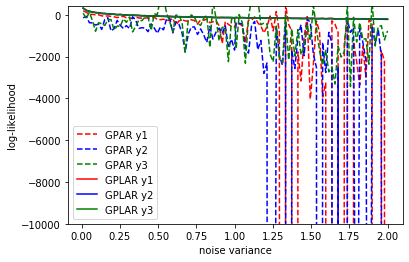

In [8]:
noise = np.concatenate((np.linspace(0.01,1.0,50),np.linspace(1.01,2.0,50)),axis=0)
plt.plot(noise, logliks_gpar_[:,0], 'r--',  label='GPAR y1')
plt.plot(noise, logliks_gpar_[:,1], 'b--',  label='GPAR y2')
plt.plot(noise, logliks_gpar_[:,2], 'g--', label='GPAR y3')
plt.plot(noise, logliks_gplar_[:,0], 'r-', label='GPLAR y1')
plt.plot(noise, logliks_gplar_[:,1], 'b-', label='GPLAR y2')
plt.plot(noise, logliks_gplar_[:,2], 'g-',  label='GPLAR y3')
plt.legend()
plt.ylabel('log-likelihood')
plt.xlabel('noise variance')
plt.ylim(-10000,400)
plt.savefig('hll-vs-noise-longer.png', dpi=300)

Text(0.5, 0, 'noise variance')

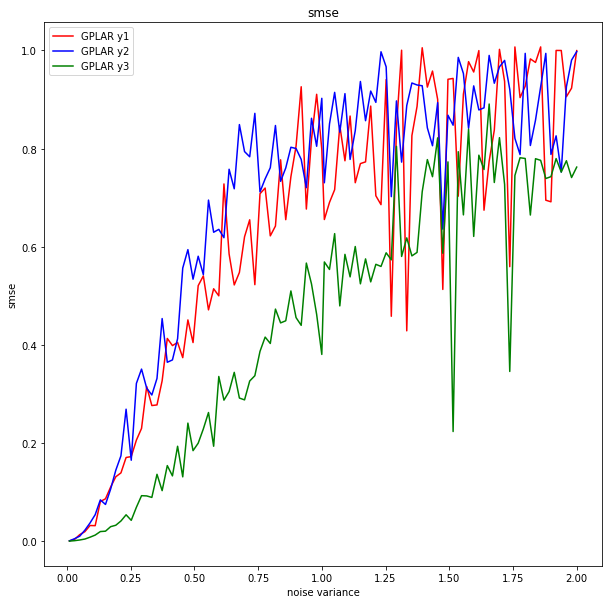

In [28]:
plt.figure(figsize=(10,10))
plt.plot(noise, smses_gplar_[:,0], 'r-', label='GPLAR y1')
plt.plot(noise, smses_gplar_[:,1], 'b-', label='GPLAR y2')
plt.plot(noise, smses_gplar_[:,2], 'g-', label='GPLAR y3')
plt.legend()
plt.title('smse')
plt.ylabel('smse')
plt.xlabel('noise variance')
#plt.savefig('smse-vs-noise-longer.png', dpi=300)

Text(0.5, 0, 'noise variance')

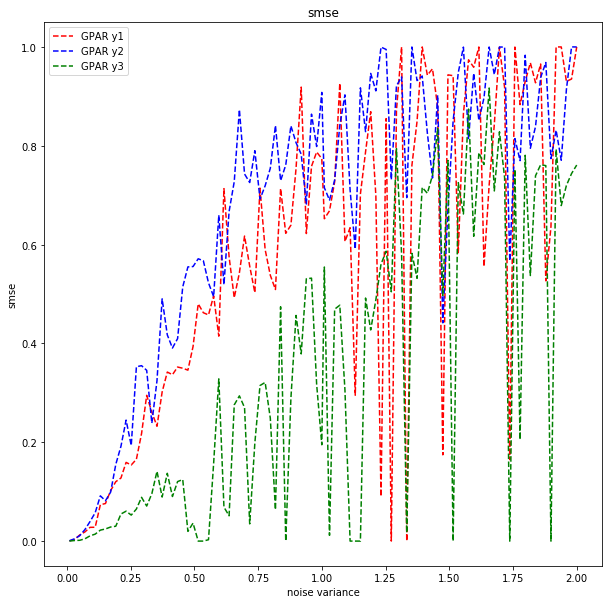

In [27]:
plt.figure(figsize=(10,10))
plt.plot(noise, smses_gpar_[:,0], 'r--', label='GPAR y1')
plt.plot(noise, smses_gpar_[:,1], 'b--', label='GPAR y2')
plt.plot(noise, smses_gpar_[:,2], 'g--', label='GPAR y3')
plt.legend()
plt.title('smse')
plt.ylabel('smse')
plt.xlabel('noise variance')